# Imports

In [1]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle
import pickle
import h5py
import json
import matplotlib.pyplot as plt 

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk import word_tokenize

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.models import model_from_json


# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook



/Users/akanshajain/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading Data

In [2]:
def ingest():
    data = pd.read_csv('./trainingandtestdata/tweets.csv', encoding='latin-1') # Enter your file location
    data.columns=["Sentiment","ItemID","Date","Blank","SentimentSource","SentimentText"]
    data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map( {4:1, 0:0}) #Converting 4 to 1
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    print ('dataset loaded with shape', data.shape  )  
    return data

data = ingest()

dataset loaded with shape (1599999, 4)


# Processing Data

In [3]:
tokenizer = TweetTokenizer()
def tokenize(tweet):
    try:
        tweet = tweet.lower()
        tokens = tokenizer.tokenize(tweet)
        tokens = list(filter(lambda t: not t.startswith('@'), tokens))
        tokens = list(filter(lambda t: not t.startswith('#'), tokens))
        tokens = list(filter(lambda t: not t.startswith('http'), tokens))
        return tokens
    except:
        return 'NC'

In [4]:
def postprocess(data):
#     , n=1000000
#     data = data.head(n)
    data['tokens'] = data['SentimentText'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

data = postprocess(data)

progress-bar: 100%|██████████| 1599999/1599999 [02:13<00:00, 11983.18it/s]


# Labelise Data

In [5]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [6]:
#Splitting for training and testing
x_train, x_test, y_train, y_test = train_test_split(np.array(data.head(1000000).tokens),
                                                    np.array(data.head(1000000).Sentiment), test_size=0.2)


In [7]:
x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST') 

800000it [00:05, 145977.28it/s]
200000it [00:00, 255565.58it/s]


In [8]:
data_labellised= labelizeTweets(np.array(data.tokens), 'data')

1599999it [00:09, 173723.07it/s]


# Builidng word2vec vocabulary and training

In [9]:
n=1000000
n_dim = 200
tweet_w2v = Word2Vec(size=n_dim, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(data_labellised)])

100%|██████████| 1599999/1599999 [00:00<00:00, 2213272.08it/s]


In [10]:
tweet_w2v.train([x.words for x in tqdm(data_labellised)],total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter) 

100%|██████████| 1599999/1599999 [00:00<00:00, 2257754.66it/s]


85543180

In [11]:
#Save the w2v model
#tweet_w2v.save('w2vmodel')
#Load the w2v model
#new_w2vmodel = gensim.models.Word2Vec.load('w2vmodel')

In [12]:
#convert any word(present in vocabulary) to vector.
tweet_w2v['bye']

array([ 1.0461875 ,  1.6774974 , -1.8338505 ,  0.08876215, -0.04538746,
       -1.3220088 , -0.62573403,  1.0442392 , -0.89215475, -0.56388116,
        1.1287812 ,  0.13112532, -0.14974174,  0.5519972 , -1.2949997 ,
        0.6965251 ,  0.55251515,  2.0572195 ,  0.00463471, -0.22994787,
        1.0968423 ,  1.0037959 , -0.25918227, -0.37408197, -0.68009204,
        0.08221306,  1.6578364 , -0.7666577 , -0.07904757,  1.5882611 ,
        1.134124  ,  0.4711224 ,  0.23346518, -1.9784242 ,  1.7873375 ,
       -1.1386204 ,  2.0458167 ,  1.0463535 ,  2.6934621 , -0.39332026,
       -2.0287223 ,  0.17158955,  1.4613515 , -1.1901448 , -0.6021148 ,
       -0.753978  ,  0.2812043 , -0.06503192,  0.27719417, -1.8744005 ,
        0.9359973 , -0.02564686, -0.55944467, -1.7382059 ,  0.2532459 ,
       -0.26935634, -1.5110639 , -0.93959284, -0.02453436, -1.1163819 ,
        1.9956712 , -0.4468748 ,  0.47275513, -1.2064052 ,  0.8054817 ,
       -0.50726974,  1.9403414 ,  1.2510912 ,  0.95988303,  0.31

In [13]:
#Find similar words
tweet_w2v.most_similar('fever')

[('cough', 0.7215234637260437),
 ('migraine', 0.7033078670501709),
 ('headache', 0.6893624067306519),
 ('toothache', 0.6594542264938354),
 ('bronchitis', 0.6463197469711304),
 ('virus', 0.6354368925094604),
 ('flu', 0.6306766867637634),
 ('migrane', 0.6067726612091064),
 ('sinus', 0.597709059715271),
 ('throat', 0.5975997447967529)]

# Plotting the vectors

In [14]:
# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
                        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                        x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.049s...
[t-SNE] Computed neighbors for 5000 samples in 10.733s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.692618
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.415138
[t-SNE] Error after 1000 iterations: 2.315913


# TF-IDF matrix of data

In [15]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in data_labellised])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 35104


In [16]:
#Save the tfidf 
# with open("tfidfdict.txt", "wb") as myFile:
#     pickle.dump(tfidf, myFile)
# with open("tfidfdict.txt", "rb") as myFile:
#     tfidf = pickle.load(myFile)


# Build tweet vector to give input to FFNN

In [17]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word] #combining w2v vectors with tfidf value of words in the tweet.
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [18]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

800000it [02:56, 4534.14it/s]
200000it [00:44, 4503.55it/s]


# Training 3 layered FFNN

In [19]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=10000, verbose=2)

Epoch 1/100
 - 3s - loss: 0.4687 - acc: 0.7978
Epoch 2/100
 - 2s - loss: 0.3731 - acc: 0.8463
Epoch 3/100
 - 2s - loss: 0.3565 - acc: 0.8529
Epoch 4/100
 - 2s - loss: 0.3490 - acc: 0.8554
Epoch 5/100
 - 2s - loss: 0.3444 - acc: 0.8569
Epoch 6/100
 - 2s - loss: 0.3412 - acc: 0.8581
Epoch 7/100
 - 2s - loss: 0.3387 - acc: 0.8590
Epoch 8/100
 - 2s - loss: 0.3367 - acc: 0.8598
Epoch 9/100
 - 2s - loss: 0.3350 - acc: 0.8605
Epoch 10/100
 - 2s - loss: 0.3336 - acc: 0.8608
Epoch 11/100
 - 2s - loss: 0.3324 - acc: 0.8614
Epoch 12/100
 - 2s - loss: 0.3313 - acc: 0.8619
Epoch 13/100
 - 2s - loss: 0.3303 - acc: 0.8624
Epoch 14/100
 - 2s - loss: 0.3294 - acc: 0.8627
Epoch 15/100
 - 3s - loss: 0.3286 - acc: 0.8631
Epoch 16/100
 - 3s - loss: 0.3278 - acc: 0.8634
Epoch 17/100
 - 2s - loss: 0.3272 - acc: 0.8639
Epoch 18/100
 - 2s - loss: 0.3267 - acc: 0.8641
Epoch 19/100
 - 3s - loss: 0.3260 - acc: 0.8644
Epoch 20/100
 - 2s - loss: 0.3255 - acc: 0.8645
Epoch 21/100
 - 2s - loss: 0.3250 - acc: 0.8648
E

In [20]:
# Evaluating accuracy score

score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])

loss :  0.3284684219646454 
 acc :  0.864015


# Saving model

In [21]:
#Saving the model
model_json = model.to_json() # serialize model to JSON
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("smodel.h5") # serialize weights to HDF5
print("Saved model to disk")

#Loading the model
# newmodel = model_from_json(open('model.json').read())
# newmodel.load_weights('smodel.h5')

Saved model to disk


# Predicting for test file (Validation)

In [22]:
def ingesttest():
    testdata = pd.read_csv('./trainingandtestdata/tweetstest.csv', encoding='latin-1')
    testdata.columns=["Sentiment","ItemID","Date","Blank","SentimentSource","SentimentText"]
    testdata.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    testdata = testdata[testdata.Sentiment.isnull() == False]
    testdata['Sentiment'] = testdata['Sentiment'].map( {4:1, 0:0, 2:1})
    testdata = testdata[testdata['SentimentText'].isnull() == False]
    testdata.reset_index(inplace=True)
    testdata.drop('index', axis=1, inplace=True)
    print ('dataset loaded with shape', testdata.shape  )  
    return testdata

testdata = ingesttest()

dataset loaded with shape (497, 4)


In [23]:
testdata = postprocess(testdata)
testdata.head(5)

progress-bar: 100%|██████████| 497/497 [00:00<00:00, 11201.28it/s]


,Sentiment,Date,Blank,SentimentText,tokens
0,1,Mon May 11 03:18:03 UTC 2009,kindle2,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle, 2, ..., love, it, ..., l..."
1,1,Mon May 11 03:18:54 UTC 2009,kindle2,"Ok, first assesment of the #kindle2 ...it fuck...","[ok, ,, first, assesment, of, the, ..., it, fu..."
2,1,Mon May 11 03:19:04 UTC 2009,kindle2,@kenburbary You'll love your Kindle2. I've had...,"[you'll, love, your, kindle, 2, ., i've, had, ..."
3,1,Mon May 11 03:21:41 UTC 2009,kindle2,@mikefish Fair enough. But i have the Kindle2...,"[fair, enough, ., but, i, have, the, kindle, 2..."
4,1,Mon May 11 03:22:00 UTC 2009,kindle2,@richardebaker no. it is too big. I'm quite ha...,"[no, ., it, is, too, big, ., i'm, quite, happy..."


In [24]:
test_X=np.array(testdata.tokens)
test_y=np.array(testdata.Sentiment)

In [25]:
test_w2v_vecs = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, test_X))])

497it [00:00, 4713.14it/s]


In [26]:
test_w2v_vecs.shape

(497, 200)

In [27]:
# model.predict_classes(test_w2v_vecs)
score = model.evaluate(test_w2v_vecs,test_y, batch_size=128, verbose=2)
print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])

loss :  0.5743939469997552 
 acc :  0.7384305879383739


# Testing the model on an user's input

In [28]:
query=input()

I took amoxicillin and I feel better now. It works.


In [29]:
n_dim = 200
querytokens=tokenize(query)
query_vecs_w2v = buildWordVector(querytokens, n_dim)
model.predict_classes(query_vecs_w2v).item()

1

# Predicting for tweets that I downloaded

In [30]:
import json
tweets = []
import pandas as pd

with open('amoxicillin_search.json', 'r') as f: #Enter name of tweets json file
    for line in f.readlines():
        tweets.append(json.loads(line))

n_dim = 200

tweet=pd.DataFrame()
tweet['text']=list(map(lambda tweet: tweet['full_text'],tweets))

In [31]:
tweet.head()

,text
0,can amoxicillin treat uti https://t.co/1wEXroE...
1,doxycycline vs amoxicillin https://t.co/DH81uR...
2,"Lincomycin, Clindamycin, ampicillin, amoxicill..."
3,#amoxicillin vs ciprofloxacin https://t.co/PUy...
4,Out here getting sautéed on amoxicillin


In [32]:
def postprocessjson(data, n=1000000):
    data = data.head(n)
    data['tokens'] = data['text'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data



In [33]:
querydata = postprocessjson(tweet)
querydata.head()

progress-bar: 100%|██████████| 577/577 [00:00<00:00, 9245.30it/s]


,text,tokens
0,can amoxicillin treat uti https://t.co/1wEXroE...,"[can, amoxicillin, treat, uti, amoxicillin]"
1,doxycycline vs amoxicillin https://t.co/DH81uR...,"[doxycycline, vs, amoxicillin, can, i, buy, do..."
2,"Lincomycin, Clindamycin, ampicillin, amoxicill...","[lincomycin, ,, clindamycin, ,, ampicillin, ,,..."
3,#amoxicillin vs ciprofloxacin https://t.co/PUy...,"[vs, ciprofloxacin, reaction, to, cipro, drug]"
4,Out here getting sautéed on amoxicillin,"[out, here, getting, sautéed, on, amoxicillin]"


In [36]:
query=np.array(querydata.tokens)
query_w2v_vecs = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, query))])

577it [00:00, 4630.60it/s]


In [37]:
result=model.predict_classes(query_w2v_vecs)

In [38]:
countone=0
countzero=0
for i,j in enumerate(result):
    if result[i].item()==0:
        countzero += 1
    if result[i].item()==1:
        countone +=1
        
Positive_Tweets =(countone/len(result))*100
Negative_Tweets =(countzero/len(result))*100
print('Positive Tweets %: ',Positive_Tweets)
print('Negative Tweets %: ',Negative_Tweets)

Positive Tweets %:  51.47313691507799
Negative Tweets %:  48.52686308492201


# Plot the sentiments

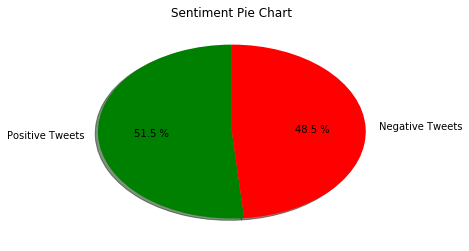

In [39]:
plt.pie([Positive_Tweets,Negative_Tweets ],
        labels=['Positive Tweets','Negative Tweets'],
        colors=['g','r'],
        startangle=90,
        shadow= True,
        autopct='%1.1f %%')
plt.title('Sentiment Pie Chart')
plt.savefig(' sentiment')